# Installing Packages and Dependencies

In [1]:
!pip install tensorflow-text==2.4.2
!pip install tf-models-official==2.4
!pip install tensorflow-gpu==2.4.2
!pip install delayed
!pip install alt-profanity-check
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import joblib
from profanity_check import predict, predict_prob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 3.4 MB 606 kB/s            
     |████████████████████████████████| 394.5 MB 35 kB/s              
     |████████████████████████████████| 3.8 MB 44.0 MB/s            
     |████████████████████████████████| 462 kB 44.3 MB/s            
     |████████████████████████████████| 2.9 MB 54.9 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77046 sha256=cbaf3f8a64c73453f4a54b4e5af5b168930e72a9bf22e6e42f897eadb3cae774
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Succe

2022-03-20 07:21:12.787124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to un

In [2]:
print(tf.__version__)

2.4.2


In [3]:
!nvidia-smi 

Sun Mar 20 07:21:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
tf.test.is_gpu_available()

2022-03-20 07:21:19.875878: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2022-03-20 07:21:19.876479: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-20 07:21:19.878158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-20 07:21:19.913711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 07:21:19.914325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-03-20 07:21:19.914393: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-20 07:21:19.961450: I tensorflow/stream_executor/platform/def

# Reading Training Data

In [5]:
df_train = pd.read_csv("../input/covid-misinfo/Constraint_English_Train.csv")
df_val = pd.read_csv("../input/covid-misinfo/Constraint_English_Val.csv")
df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
df = pd.concat([df_train, df_val, df_test], ignore_index=True)
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
df.shape

(10700, 3)

# Training Data Insight

In [7]:
df.groupby('label').describe()

id                                                                
        count         mean          std  min     25%     50%      75%     max
label                                                                        
fake   5100.0  2373.648627  1821.186440  1.0  902.00  1812.0  3761.50  6419.0
real   5600.0  2337.061071  1819.161764  1.0  884.75  1757.0  3726.75  6420.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


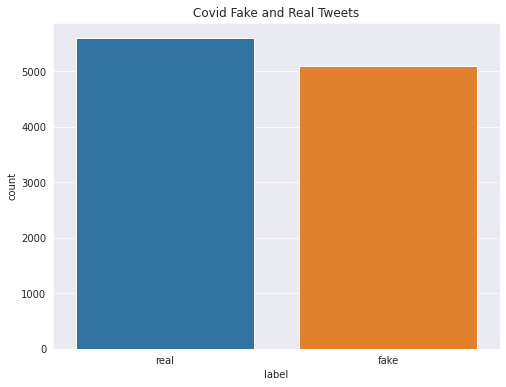

In [8]:
plt.figure(figsize=(8,6))
sns.set_style(style='darkgrid')
sns.countplot(df['label'])
plt.title("Covid Fake and Real Tweets")
plt.show()

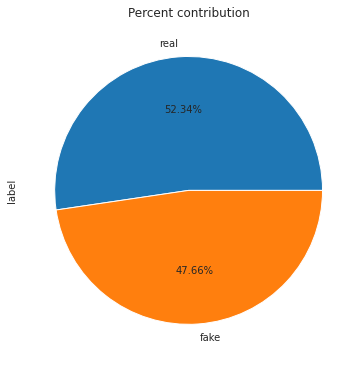

In [9]:
plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
df["label"].value_counts().plot.pie(autopct='%0.2f%%')
plt.title("Percent contribution")
plt.show()

# Feature Engineering

In [10]:
def get_prafanity_scores(text):
    embeds = []
    
    for line in tqdm(text):
        
        embeds.append(predict_prob([line])[0])
    
    assert len(text) == len(embeds)    
    return embeds

In [11]:
#textural features
def get_text_ft(text):
    tweet_len =  len(text)
    tweet_num_of_upper_char = sum([len([char for char in word if char.isupper()]) for word in text])
    tweet_num_of_qmarks = sum([len([char for char in word if char == '?']) for word in text]) 
    tweet_num_of_exclmmarks = sum([len([char for char in word if char == '!']) for word in text])
    return tweet_len, tweet_num_of_upper_char, tweet_num_of_qmarks, tweet_num_of_exclmmarks

In [12]:
df['profanity_scores'] = get_prafanity_scores(df['tweet'])
df[['length','num_of_upper_char','num_of_qmarks','num_of_exclmmarks']] = df['tweet'].apply(lambda x: get_text_ft(x)).to_list()

100%|██████████| 10700/10700 [00:19<00:00, 560.75it/s]


In [13]:
df

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
0,1,The CDC currently reports 99031 deaths. In gen...,real,0.009465,190,6,0,0
1,2,States reported 1121 deaths a small rise from ...,real,0.031755,129,10,0,0
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,0.061657,131,16,0,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0.034314,204,32,0,0
4,5,Populous states can generate large case counts...,real,0.014909,231,26,0,0
...,...,...,...,...,...,...,...,...
10695,2136,#CoronaVirusUpdates: State-wise details of Tot...,real,0.008353,300,24,0,0
10696,2137,Tonight 12(midnight) onwards Disaster Manageme...,fake,0.004930,271,7,0,0
10697,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,real,0.025429,252,30,0,0
10698,2139,RT @CDCemergency: #DYK? @CDCgovâ€™s One-Stop S...,real,0.025241,144,21,1,0


In [14]:
df.nlargest(5, 'profanity_scores')

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
2160,2161,Local Man Sick To Fucking Death Hearing About ...,fake,0.999747,85,16,0,0
4895,4896,Stoner Strung Out To Fuck Thanks To Lockdown R...,fake,0.999376,81,11,0,0
8557,2138,Nothing screams “I am sat around doing fuck al...,fake,0.997964,184,6,0,0
4927,4928,Ellie Goulding says she’s amazed there were 20...,fake,0.993335,174,13,1,0
8861,302,#covid19 #coronavirus #coronaoutbreak Â£10 for...,fake,0.985309,251,14,0,9


In [15]:
df.nlargest(5, 'num_of_qmarks')

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
5464,5465,"Says Sarah Huckabee Sanders tweeted, ???It???s...",fake,0.015965,338,28,34,0
8695,136,Italy ???went against the WHO's ???law?????ï¿½...,fake,0.121505,198,9,21,0
3045,3046,???President Trump just announced that the ???...,fake,0.008184,219,13,17,1
3291,3292,"Quotes Anthony Fauci as writing, ???I reject t...",fake,0.082221,165,5,17,0
4420,4421,"Trey Gowdy said, ???I???m not saying COVID-19 ...",fake,0.109564,149,9,17,0


# Normalizing

In [16]:
df['length'] = MinMaxScaler().fit_transform(np.array(df['length']).reshape(-1,1))
df['num_of_upper_char'] = MinMaxScaler().fit_transform(np.array(df['num_of_upper_char']).reshape(-1,1))
df['num_of_qmarks'] = MinMaxScaler().fit_transform(np.array(df['num_of_qmarks']).reshape(-1,1))
df['num_of_exclmmarks'] = MinMaxScaler().fit_transform(np.array(df['num_of_exclmmarks']).reshape(-1,1))

In [17]:
df

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
0,1,The CDC currently reports 99031 deaths. In gen...,real,0.009465,0.016761,0.006865,0.000000,0.0
1,2,States reported 1121 deaths a small rise from ...,real,0.031755,0.010817,0.011442,0.000000,0.0
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,0.061657,0.011011,0.018307,0.000000,0.0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0.034314,0.018125,0.036613,0.000000,0.0
4,5,Populous states can generate large case counts...,real,0.014909,0.020756,0.029748,0.000000,0.0
...,...,...,...,...,...,...,...,...
10695,2136,#CoronaVirusUpdates: State-wise details of Tot...,real,0.008353,0.027480,0.027460,0.000000,0.0
10696,2137,Tonight 12(midnight) onwards Disaster Manageme...,fake,0.004930,0.024654,0.008009,0.000000,0.0
10697,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,real,0.025429,0.022803,0.034325,0.000000,0.0
10698,2139,RT @CDCemergency: #DYK? @CDCgovâ€™s One-Stop S...,real,0.025241,0.012278,0.024027,0.029412,0.0


# Data Preprocessing

In [18]:
#Data Cleaning
ps = PorterStemmer()
nltk.download("stopwords")
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def cleaner(text):
    try:
        url_re = re.compile(r'(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?')
        cleaned = url_re.sub("",text)
        #print(cleaned)
        
        hashtag_re = re.compile(r'(#\w+)')
        cleaned = hashtag_re.sub("",cleaned)
        #print(cleaned)
        
        screen_name_re = re.compile(r'(@\w+)')
        cleaned = screen_name_re.sub("", cleaned)
        #print(cleaned)
        
        emoji_re = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U0001F1F2-\U0001F1F4"  # Macau flag
                u"\U0001F1E6-\U0001F1FF"  # flags
                u"\U0001F600-\U0001F64F"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U0001F1F2"
                u"\U0001F1F4"
                u"\U0001F620"
                u"\u200d"
                u"\u2640-\u2642"
                "]+", flags=re.UNICODE)
        cleaned = emoji_re.sub("",cleaned)
        #print(cleaned)
        
        cleaned = cleaned.replace("."," ").replace("//"," ")
        cleaned = re.sub(r'[^a-zA-Z]', " ", cleaned) #Replacing all non-alphabets with " "
        cleaned = re.sub(r'\w+\d+', " ", cleaned) #Removes alphanumeric words
        #print("Before Stemming: ",cleaned)
        cleaned = ps.stem(cleaned)
        #print("After Stemming: ",cleaned)
        cleaned = " ".join([word for word in cleaned.split() if len(word)>2]) #Removing words with len<2
        cleaned = ' '.join([word for word in cleaned.split() if word not in en_stopwords])
        #print(cleaned)
        cleaned = cleaned.strip() #Removing whitespaces
        cleaned = cleaned.lower() #Converting to lower case
        #print("After Stemming Split: ",cleaned)
    except:
        cleaned = ""
    return cleaned

In [20]:
df['tweet'] = df['tweet'].apply(lambda text: cleaner(text))
df.head()

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
0,1,cdc currently reports deaths general discrepan...,real,0.009465,0.016761,0.006865,0.0,0.0
1,2,states reported deaths small rise last tuesday...,real,0.031755,0.010817,0.011442,0.0,0.0
2,3,politically correct woman almost uses pandemic...,fake,0.061657,0.011011,0.018307,0.0,0.0
3,4,testing laboratories india august tests done,real,0.034314,0.018125,0.036613,0.0,0.0
4,5,populous states generate large case counts loo...,real,0.014909,0.020756,0.029748,0.0,0.0


# Generating Word Clouds

In [21]:
#Function to get word frequencies in the data
def get_word_freqs(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

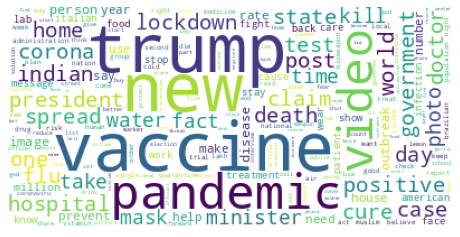

In [22]:
freq_words_fake = get_word_freqs(df[df['label']=='fake'],'tweet')
freq_words_fake = " ".join(freq_words_fake.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_fake)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

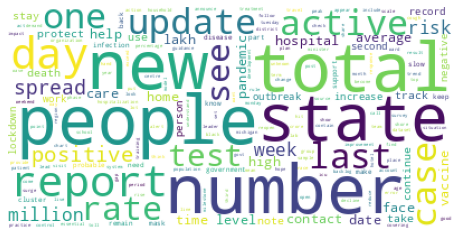

In [23]:
freq_words_real = get_word_freqs(df[df['label']=='real'],'tweet')
freq_words_real = " ".join(freq_words_real.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_real)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [24]:
#splitting the labels
df_real = df[df['label']=='real']
df_real.shape

(5600, 8)

In [25]:
df_fake = df[df['label']=='fake']
df_fake.shape

(5100, 8)

# Downsampling Data

In [26]:
#unbalanced data so we downsample it
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(5100, 8)

In [27]:
df_balanced = pd.concat([df_fake, df_real_downsampled])
df_balanced['label'].value_counts()

fake    5100
real    5100
Name: label, dtype: int64

In [28]:
df_balanced['fake'] = df_balanced['label'].apply(lambda x: 1 if x == 'fake' else 0)
df_balanced.sample(5)

,id,tweet,label,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks,fake
5045,5046,air india chicago delhi flight passengers charged,fake,0.017808,0.005554,0.005721,0.0,0.0,1
6563,144,people treated rajasthan first indian state ge...,fake,0.031393,0.018710,0.009153,0.0,0.0,1
2928,2929,india records positive cases total confirmed c...,fake,0.007410,0.026603,0.019451,0.0,0.0,1
1111,1112,one wrinkle data one way think know missing lo...,real,0.034626,0.017930,0.003432,0.0,0.0,0
7181,762,covid means vaccination identification certifi...,fake,0.034014,0.020854,0.026316,0.0,0.0,1


In [29]:
df_features = df_balanced[["profanity_scores", "length","num_of_upper_char", "num_of_qmarks", "num_of_exclmmarks"]]
df_features

,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
2,0.061657,0.011011,0.018307,0.000000,0.0
7,0.008688,0.006334,0.016018,0.000000,0.0
8,0.037274,0.007991,0.002288,0.147059,0.0
9,0.019782,0.014812,0.013730,0.000000,0.0
11,0.027528,0.019489,0.017162,0.000000,0.0
...,...,...,...,...,...
6,0.010152,0.022023,0.022883,0.000000,0.0
629,0.019397,0.027090,0.048055,0.000000,0.0
9491,0.017366,0.019489,0.009153,0.029412,0.0
4603,0.049863,0.020464,0.012586,0.000000,0.0


# Model Construction

In [30]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-03-20 07:22:17.254117: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-20 07:22:17.254466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 07:22:17.255133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-03-20 07:22:17.255219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-20 07:22:17.255274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-20 07:22:17.255295: I tensorflow/stream_executor/platform/

In [31]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [32]:
#Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
feature_input = tf.keras.layers.Input((5,))
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
concat= tf.keras.layers.Concatenate()([outputs['pooled_output'], feature_input])

#Neural Network Layers
dropout = tf.keras.layers.Dropout(0.1, name='dropout')(concat)
fc1 = tf.keras.layers.Dense(512, activation='relu', name='fullyConnected1')(outputs['pooled_output'])
dropout = tf.keras.layers.Dropout(0.1, name='dropout')(fc1)
fc2 = tf.keras.layers.Dense(256, activation='relu', name='fullyConnected2')(dropout)
dense = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(fc2)

# # fc1 = tf.keras.layers.Dense(512, activation='relu', name='fullyConnected1')(concat)
# # dropout = tf.keras.layers.Dropout(0.1, name='dropout')(fc1)
# # fc2 = tf.keras.layers.Dense(256, activation='relu', name='fullyConnected2')(dropout)
# # dense = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(fc2)

#Final Model
model = tf.keras.Model(inputs=[text_input, feature_input], outputs=[dense])

In [33]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [34]:
# #Bert Layers
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# preprocessed_text = bert_preprocess(text_input)
# outputs = bert_encoder(preprocessed_text)

# #Neural Network Layers
# fc1 = tf.keras.layers.Dense(512, activation='relu', name='fullyConnected1')(outputs['pooled_output'])
# dropout = tf.keras.layers.Dropout(0.1, name='dropout')(fc1)
# fc2 = tf.keras.layers.Dense(256, activation='relu', name='fullyConnected2')(dropout)
# dense = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(fc2)

# #Final Model
# model2 = tf.keras.Model(inputs=[text_input], outputs=[dense])

In [35]:
# #Bert Layers
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# preprocessed_text = bert_preprocess(text_input)
# outputs = bert_encoder(preprocessed_text)

# #Neural Network Layers
# fc1 = tf.keras.layers.Dense(512, activation='relu', name='fullyConnected1')(outputs['pooled_output'])
# dropout = tf.keras.layers.Dropout(0.1, name='dropout')(fc1)
# fc2 = tf.keras.layers.Dense(256, activation='relu', name='fullyConnected2')(dropout)
# dense = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(fc2)

# #Final Model
# model2 = tf.keras.Model(inputs=[text_input], outputs=[dense])

In [36]:
X_train = df_balanced[['tweet']] 
y_train = df_balanced[['fake']]

In [37]:
# df_val = pd.read_csv("../input/covid-misinfo/Constraint_English_Val.csv")
# df_val['tweet'] = df_val['tweet'].apply(lambda text: cleaner(text))
# df_val['fake'] = df_val['label'].apply(lambda x: 1 if x == 'fake' else 0)
# X_val = df_val[['tweet']] 
# y_val = df_val[['fake']]

In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                              mode='min',
                              verbose=1,
                              patience=3,
                              min_delta=0.0001,
                              factor=0.2
                             )
]

# Training the Model

In [39]:
X_train

,tweet
2,politically correct woman almost uses pandemic...
7,obama calls trump coronavirus response chaotic...
8,clearly obama administration leave kind game p...
9,retraction hydroxychloroquine chloroquine with...
11,nba poised restart month march reported utah j...
...,...
6,tested positive symptoms stay home away people...
629,consumer affairs agency japan warned people ea...
9491,common question coronavirus cases going testin...
4603,second case woman arrived new zealand august p...


In [40]:
df_features

,profanity_scores,length,num_of_upper_char,num_of_qmarks,num_of_exclmmarks
2,0.061657,0.011011,0.018307,0.000000,0.0
7,0.008688,0.006334,0.016018,0.000000,0.0
8,0.037274,0.007991,0.002288,0.147059,0.0
9,0.019782,0.014812,0.013730,0.000000,0.0
11,0.027528,0.019489,0.017162,0.000000,0.0
...,...,...,...,...,...
6,0.010152,0.022023,0.022883,0.000000,0.0
629,0.019397,0.027090,0.048055,0.000000,0.0
9491,0.017366,0.019489,0.009153,0.029412,0.0
4603,0.049863,0.020464,0.012586,0.000000,0.0


In [41]:
#tf.config.run_functions_eagerly(True)

In [42]:
h1 = model.fit(x=[X_train, df_features], y=y_train, epochs= 40, callbacks = callbacks, verbose=1)

Epoch 1/40


2022-03-20 07:22:59.870590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-20 07:23:00.604048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


319/319 [==============================] - 76s 212ms/step - loss: 0.5698 - accuracy: 0.7039 - precision: 0.7006 - recall: 0.6820
Epoch 2/40
319/319 [==============================] - 68s 212ms/step - loss: 0.3757 - accuracy: 0.8364 - precision: 0.8347 - recall: 0.8423
Epoch 3/40
319/319 [==============================] - 68s 212ms/step - loss: 0.3551 - accuracy: 0.8478 - precision: 0.8442 - recall: 0.8478
Epoch 4/40
319/319 [==============================] - 67s 211ms/step - loss: 0.3578 - accuracy: 0.8461 - precision: 0.8438 - recall: 0.8421
Epoch 5/40
319/319 [==============================] - 68s 214ms/step - loss: 0.3310 - accuracy: 0.8544 - precision: 0.8524 - recall: 0.8629
Epoch 6/40
319/319 [==============================] - 68s 212ms/step - loss: 0.3196 - accuracy: 0.8616 - precision: 0.8554 - recall: 0.8723
Epoch 7/40
319/319 [==============================] - 68s 212ms/step - loss: 0.3340 - accuracy: 0.8556 - precision: 0.8496 - recall: 0.8600
Epoch 8/40
319/319 [===========

In [43]:
h1.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'lr'])

In [44]:
def plot_metrics(h):
    #Plotting metrics
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss']);
    plt.title("Loss vs Epochs");
    plt.ylabel("Loss");
    plt.xlabel("Epochs");
    plt.legend(['train']);

    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'])
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train'], loc='upper left')
    plt.show()

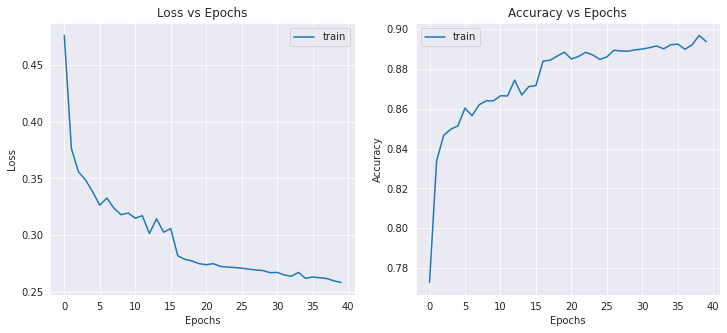

In [45]:
plot_metrics(h1)

In [46]:
model.save('Final_BERT_TextFt_10K.h5')

# Model Evaluation on Test Data

In [47]:
# #Preprocessing
# df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
# df_test['tweet'] = df_test['tweet'].apply(lambda text: cleaner(text))
# df_test['fake'] = df_test['label'].apply(lambda x: 1 if x == 'fake' else 0)
# X_test = df_test[['tweet']] 
# y_test = df_test[['fake']]

# X_test.shape

In [48]:
# #Feature Extraction
# df_test['profanity_scores'] = get_prafanity_scores(df_test['tweet'])
# df_test[['length','num_of_upper_char','num_of_qmarks','num_of_exclmmarks']] = df_test['tweet'].apply(lambda x: get_text_ft(x)).to_list()

# #Normalizing
# df_test['length'] = MinMaxScaler().fit_transform(np.array(df_test['length']).reshape(-1,1))
# df_test['num_of_upper_char'] = MinMaxScaler().fit_transform(np.array(df_test['num_of_upper_char']).reshape(-1,1))
# df_test['num_of_qmarks'] = MinMaxScaler().fit_transform(np.array(df_test['num_of_qmarks']).reshape(-1,1))
# df_test['num_of_exclmmarks'] = MinMaxScaler().fit_transform(np.array(df_test['num_of_exclmmarks']).reshape(-1,1))

# df_test_features = df_test[["profanity_scores", "length","num_of_upper_char", "num_of_qmarks", "num_of_exclmmarks"]]

In [49]:
# test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x=[X_test,df_test_features], y=y_test)

# print("Test Loss: ", test_loss)
# print("Test Precision: ", test_precision)
# print("Test Recall: ", test_recall)
# print("Test Accuracy: ", test_accuracy)

In [50]:
# y_pred = model.predict([X_test,df_test_features])
# y_pred = y_pred.flatten()
# y_pred = np.where(y_pred>0.5, 1, 0)

In [51]:
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()